In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tqdm import tqdm

# ----------------------------------------------------------
# Paths
# ----------------------------------------------------------
project_root = "/home/carolina/Documentos/Aulas/ACII/project"
features_dir = os.path.join(project_root, "features_cache")
models_dir = os.path.join(project_root, "saved_models")

# Number of classes in UrbanSound8K
num_classes = df_paths["label"].nunique()  # usually 10

# **DeepFool para CNN**

Modelos de aprendizagem profunda para classificação de áudio, incluindo Redes Neurais Convolucionais (CNNs), têm demonstrado um forte desempenho em tarefas como o reconhecimento de sons ambientais. No entanto, esses modelos são conhecidos por serem vulneráveis a exemplos adversários , isto é, entradas que foram intencionalmente modificadas com pequenas perturbações, muitas vezes impercetíveis, que fazem com que o modelo faça previsões erradas.

Para avaliar a robustez do nosso classificador UrbanSound8K, usamos o DeepFool, um ataque adversário bem estabelecido, projetado para encontrar a perturbação mínima necessária para enganar um modelo. Ao contrário de ataques mais fortes, mas mais brutais, o DeepFool é um ataque iterativo, baseado em geometria, que estima o limite de decisão mais próximo e calcula o menor passo necessário para cruzá-lo.

A aplicação do DeepFool aos espectrogramas Mel permite-nos quantificar:

- A facilidade com que cada amostra pode ser perturbada, levando a uma classificação errada

- A magnitude que a perturbação deve ter 

- Quais classes são mais ou menos vulneráveis

- Como a robustez do modelo varia entre as folds de validação cruzada

Ao avaliar todas as amostras de teste em todas as folds, obtemos uma visão completa da suscetibilidade adversária do modelo e podemos comparar a robustez com a precisão. Esta análise fornece informações valiosas sobre a fiabilidade, generalização e potenciais pontos fracos do modelo.

In [ ]:
import os
import re
import pandas as pd

# Path to project folder
project_root = "/home/carolina/Documentos/Aulas/ACII/project"
features_dir = os.path.join(project_root, "features_cache")

rows = []

# Regex that matches filenames
pattern = re.compile(r"fold(\d+)_(.+)_mel_aug(\d+)\.npy")

for fname in os.listdir(features_dir):
    if not fname.endswith(".npy"):
        continue

    match = pattern.match(fname)
    if not match:
        continue  # skip files that don’t fit mel name pattern

    fold = int(match.group(1))
    us8k_name = match.group(2)
    aug = int(match.group(3))

    # Extract label from US8K filename: e.g., 102106-3-0-0 → class "3"
    label = int(us8k_name.split("-")[1])  # second field is the class ID

    rows.append({
        "fold": fold,
        "filename": us8k_name,
        "label": label,
        "augmented": aug,
        "mel_path": os.path.join(features_dir, fname)
    })

df_paths = pd.DataFrame(rows)

print(df_paths.head())
print("Total mel files found:", len(df_paths))


   fold       filename  label  augmented  \
0     4   169466-4-0-7      4          1   
1     7    83488-1-0-0      1          1   
2     4  159751-8-0-21      8          1   
3     7    34871-3-6-0      3          0   
4     3  185375-9-0-60      9          1   

                                            mel_path  
0  /home/carolina/Documentos/Aulas/ACII/project/f...  
1  /home/carolina/Documentos/Aulas/ACII/project/f...  
2  /home/carolina/Documentos/Aulas/ACII/project/f...  
3  /home/carolina/Documentos/Aulas/ACII/project/f...  
4  /home/carolina/Documentos/Aulas/ACII/project/f...  
Total mel files found: 17464


Esta função implementa o ataque adversário DeepFool para uma única imagem de input.
O DeepFool lineariza iterativamente o classificador em torno do ponto atual e calcula a perturbação mínima necessária para alterar a decisão do modelo. Em cada iteração, ele:

- Calcula os gradientes dos logits para a classe verdadeira e todas as outras classes.

- Estima a menor perturbação que empurraria a amostra através de um limite de decisão.

- Acumula essa perturbação e atualiza a imagem adversária.

- Para mais cedo se o modelo alterar o rótulo previsto.

A função retorna tanto a imagem adversária final quanto a perturbação total adicionada.

In [4]:
def deepfool_single_image(model, image, num_classes=10, max_iter=50, epsilon=1e-6):
    img = tf.convert_to_tensor(image[None, ...], dtype=tf.float32)
    f_image = model(img)[0]  
    label = tf.argmax(f_image)

    pert_image = tf.identity(img)
    r_tot = tf.zeros_like(img)

    for _ in range(max_iter):
        with tf.GradientTape() as tape:
            tape.watch(pert_image)
            preds = model(pert_image)[0]  # shape (num_classes,)

        current_class = tf.argmax(preds)
        if current_class != label:
            break

        min_perturb = float("inf")
        best_w = None

        for k in range(num_classes):
            if k == label:
                continue

            # Gradient of k-th logit
            with tf.GradientTape() as tape_k:
                tape_k.watch(pert_image)
                f_k = model(pert_image)[0][k]
            grad_k = tape_k.gradient(f_k, pert_image)

            # Gradient of true label logit
            with tf.GradientTape() as tape_l:
                tape_l.watch(pert_image)
                f_l = model(pert_image)[0][label]
            grad_l = tape_l.gradient(f_l, pert_image)

            w_k = grad_k - grad_l
            f_k_val = preds[k] - preds[label]
            pert_k = tf.abs(f_k_val) / (tf.norm(tf.reshape(w_k, [-1])) + epsilon)

            if pert_k < min_perturb:
                min_perturb = pert_k
                best_w = w_k

        r_i = (min_perturb + epsilon) * best_w / (tf.norm(tf.reshape(best_w, [-1])) + epsilon)
        r_tot += r_i
        pert_image = img + r_tot
        pert_image = tf.clip_by_value(pert_image, 0.0, 1.0)

    return pert_image[0].numpy(), r_tot[0].numpy()


In [5]:
def compute_relative_perturbation(original, perturbation):
    return np.linalg.norm(perturbation) / (np.linalg.norm(original) + 1e-8)

Esta célula executa o ataque adversário DeepFool em todas as amostras de teste de cada dobra na sua configuração de validação cruzada.
Para cada fold, ela:

1. Carrega o modelo treinado para essa fold.

2. Seleciona todas as amostras de teste não aumentadas pertencentes a essa fold.

3. Para cada espectrograma de teste:

    - Carrega o espectrograma Mel e obtém a previsão original.

    - Aplica o ataque DeepFool para gerar uma versão adversária.

    - Obtém a previsão adversária do modelo.

    - Calcula a magnitude relativa da perturbação, indicando o quanto o exemplo precisava ser alterado para enganar o classificador.

4. Armazena os resultados (previsão original, previsão adversária, sinalizador de sucesso e magnitude da perturbação) em um arquivo CSV para essa fold.

O output fornece um conjunto de dados completo das métricas de desempenho do DeepFool em todas as folds, permitindo a comparação posterior da robustez, taxa de sucesso do ataque e tamanho da perturbação.

In [6]:
# ----------------------------------------------------------
# DeepFool Attack on ALL test samples of ALL folds
# ----------------------------------------------------------

for fold in sorted(df_paths["fold"].unique()):
    model_path = os.path.join(models_dir, f"fold{fold}_model.h5")
    if not os.path.exists(model_path):
        print(f"Model for fold {fold} not found.")
        continue

    print("\n===============================")
    print(f"DeepFool Attack on FULL Test Set: Fold {fold}")
    print("===============================")

    model = load_model(model_path)

    # Select ALL non-augmented test samples for this fold
    test_df = df_paths[(df_paths["fold"] == fold) & (df_paths["augmented"] == 0)]

    print(f"Total test samples in this fold: {len(test_df)}")

    results = []

    for idx, row in test_df.iterrows():
        mel = np.load(row["mel_path"])
        mel_input = np.expand_dims(mel, axis=-1)

        # Original prediction
        orig_pred = np.argmax(model.predict(np.array([mel_input])), axis=1)[0]

        # Apply DeepFool
        perturbed, perturbation = deepfool_single_image(
            model,
            mel_input,
            num_classes=num_classes
        )

        # Prediction after perturbation
        adv_pred = np.argmax(model.predict(np.array([perturbed])), axis=1)[0]

        # Compute relative perturbation magnitude
        rel_pert = compute_relative_perturbation(mel_input, perturbation)

        results.append({
            "filename": row["filename"],
            "label": row["label"],
            "orig_pred": orig_pred,
            "adv_pred": adv_pred,
            "rel_perturbation": rel_pert,
            "success": int(orig_pred != adv_pred)
        })

        print(f"Sample {row['filename']}: Orig={orig_pred}, Adv={adv_pred}, RelPert={rel_pert:.6f}")

    # Save results for this fold
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"deepfool_results_fold{fold}.csv", index=False)

    print(f"Saved fold {fold} results to deepfool_results_fold{fold}.csv")



DeepFool Attack on FULL Test Set: Fold 1


2025-11-29 18:35:40.688040: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Total test samples in this fold: 873
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-11-29 18:35:44.650937: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12719616 exceeds 10% of free system memory.
2025-11-29 18:35:44.992041: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12719616 exceeds 10% of free system memory.
2025-11-29 18:35:45.334356: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12719616 exceeds 10% of free system memory.
2025-11-29 18:35:45.586041: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12719616 exceeds 10% of free system memory.
2025-11-29 18:35:45.875615: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12719616 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Sample 46656-6-4-0: Orig=8, Adv=5, RelPert=0.000058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Sample 177621-0-0-27: Orig=8, Adv=5, RelPert=0.000001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Sample 180937-7-3-28: Orig=8, Adv=5, RelPert=0.032114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Sample 180937-7-1-2: Orig=8, Adv=5, RelPert=0.003813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Sample 147764-4-1-0: Orig=8, Adv=7, RelPert=6.057724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Sample 192124-2-0-11: Orig=8, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Sample 180937-7-0-1: Orig=8, Adv=5, RelPert=0.000020
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Sample 191431-9-0-30: Orig=8, Adv=0, RelPe

Total test samples in this fold: 888
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Sample 189023-0-0-3: Orig=8, Adv=3, RelPert=0.253899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Sample 113201-5-0-1: Orig=8, Adv=7, RelPert=1.020852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Sample 172593-2-0-14: Orig=2, Adv=3, RelPert=0.000582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Sample 160011-2-0-12: Orig=8, Adv=3, RelPert=0.033369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Sample 149254-9-0-25: Orig=8, Adv=7, RelPert=1.498809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Sample 152908-5-0-8: Orig=8, Adv=3, RelPert=0.002130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Sample 156893-7-8-0: Orig=8, Adv=3, RelPert=0.003672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 

Total test samples in this fold: 925
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Sample 177742-0-0-196: Orig=5, Adv=4, RelPert=0.281901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Sample 196060-2-0-0: Orig=5, Adv=4, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Sample 82811-3-0-2: Orig=5, Adv=4, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Sample 13230-0-0-28: Orig=5, Adv=4, RelPert=14.513170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Sample 144068-5-0-4: Orig=5, Adv=4, RelPert=1.116333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Sample 110622-6-0-0: Orig=5, Adv=4, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Sample 17615-3-0-0: Orig=9, Adv=4, RelPert=0.000083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━

Total test samples in this fold: 990
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Sample 34056-2-0-48: Orig=4, Adv=0, RelPert=0.000226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Sample 29722-4-0-1: Orig=4, Adv=0, RelPert=0.000419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Sample 128160-5-0-12: Orig=4, Adv=0, RelPert=0.000072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Sample 17480-2-0-25: Orig=4, Adv=0, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Sample 128160-5-0-0: Orig=4, Adv=0, RelPert=0.000152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Sample 154758-5-0-0: Orig=4, Adv=4, RelPert=0.341391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Sample 183989-3-1-18: Orig=3, Adv=0, RelPert=0.000014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━

Total test samples in this fold: 936
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Sample 185436-1-0-0: Orig=0, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Sample 139665-9-0-8: Orig=0, Adv=5, RelPert=0.000002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Sample 178686-0-0-16: Orig=0, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Sample 148841-6-1-0: Orig=0, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Sample 111671-8-0-22: Orig=0, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Sample 178497-3-0-4: Orig=0, Adv=5, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Sample 178260-7-1-3: Orig=0, Adv=7, RelPert=0.729537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━

Total test samples in this fold: 823
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Sample 18933-1-0-0: Orig=8, Adv=3, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Sample 188004-8-0-2: Orig=8, Adv=3, RelPert=0.328453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Sample 69962-2-0-2: Orig=8, Adv=3, RelPert=0.118396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Sample 31973-9-0-56: Orig=8, Adv=3, RelPert=0.007588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Sample 107842-4-2-2: Orig=8, Adv=7, RelPert=2.458361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Sample 161923-3-0-12: Orig=8, Adv=3, RelPert=0.161016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Sample 179860-1-0-0: Orig=8, Adv=3, RelPert=0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━

Total test samples in this fold: 838
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Sample 34871-3-6-0: Orig=8, Adv=4, RelPert=0.005702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Sample 177729-0-0-128: Orig=8, Adv=4, RelPert=0.002181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Sample 105289-8-2-7: Orig=8, Adv=4, RelPert=0.008045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Sample 89099-4-0-2: Orig=7, Adv=4, RelPert=0.010579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Sample 168846-5-1-6: Orig=8, Adv=4, RelPert=0.003916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Sample 189987-0-0-3: Orig=8, Adv=4, RelPert=0.003852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Sample 165192-9-0-76: Orig=8, Adv=4, RelPert=0.212861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━

Total test samples in this fold: 806
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Sample 175856-1-1-0: Orig=8, Adv=7, RelPert=0.047349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Sample 50668-5-2-0: Orig=8, Adv=7, RelPert=0.115907
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Sample 157649-3-1-1: Orig=2, Adv=4, RelPert=0.002766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Sample 156358-5-0-2: Orig=2, Adv=7, RelPert=0.185556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Sample 189825-9-0-7: Orig=2, Adv=7, RelPert=13.902905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Sample 189846-3-4-0: Orig=8, Adv=7, RelPert=0.297282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Sample 139000-4-0-0: Orig=2, Adv=7, RelPert=7.962088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━

Total test samples in this fold: 816
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Sample 188823-7-0-0: Orig=5, Adv=7, RelPert=20.715942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Sample 14385-9-0-13: Orig=8, Adv=7, RelPert=0.036131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Sample 180937-4-1-20: Orig=5, Adv=7, RelPert=14.574332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Sample 61250-3-0-36: Orig=5, Adv=7, RelPert=0.000085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Sample 192123-2-0-11: Orig=5, Adv=7, RelPert=1.715670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Sample 39856-5-0-11: Orig=5, Adv=7, RelPert=51.696381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Sample 137815-4-0-7: Orig=5, Adv=7, RelPert=0.001689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/

Total test samples in this fold: 837
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Sample 180127-4-0-5: Orig=0, Adv=3, RelPert=0.027648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Sample 189982-0-0-18: Orig=0, Adv=3, RelPert=0.002481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Sample 197554-2-0-82: Orig=0, Adv=3, RelPert=0.000790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Sample 118278-4-0-9: Orig=0, Adv=3, RelPert=0.011818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Sample 188497-2-0-19: Orig=0, Adv=3, RelPert=0.001539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Sample 165166-8-0-5: Orig=0, Adv=3, RelPert=0.001874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Sample 24076-1-1-0: Orig=8, Adv=3, RelPert=0.002324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━

### **Análise dos Resultados do DeepFool**

Após gerar os ficheiros CSV com os resultados do ataque DeepFool para cada fold, esta secção reúne e analisa todos esses dados. O objetivo é avaliar a robustez do modelo face a perturbações adversariais, comparando:

- Taxa de sucesso do ataque (quantas vezes o DeepFool alterou a previsão).

- Magnitude média da perturbação relativa necessária para enganar o modelo.

- Variações entre folds, permitindo perceber se alguns modelos são mais vulneráveis do que outros.

Esta análise fornece uma visão global do comportamento do classificador sob ataque adversarial e permite tirar conclusões sobre a sua estabilidade e sensibilidade a pequenas alterações nos espectrogramas.

In [7]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load all result CSVs
# --------------------------
csv_files = sorted(glob.glob("deepfool_results_fold*.csv"))
dfs = []

for f in csv_files:
    fold = int(f.split("fold")[1].split(".")[0])  # extract fold number
    df = pd.read_csv(f)
    df["fold"] = fold
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print("Loaded samples:", len(df_all))

Loaded samples: 8732


In [8]:
results = df_all.groupby("fold").apply(
    lambda x: pd.Series({
        "fooling_rate": (x.orig_pred != x.adv_pred).mean(),
        "mean_rel_pert": x.rel_perturbation.mean(),
        "median_rel_pert": x.rel_perturbation.median(),
        "samples": len(x)
    })
)

print(results)

      fooling_rate  mean_rel_pert  median_rel_pert  samples
fold                                                       
1         1.000000       2.889042     1.503645e-05    873.0
2         1.000000       2.696998     8.626398e-02    888.0
3         1.000000       2.041214     4.756461e-10    925.0
4         0.904040       4.133463     1.243364e-02    990.0
5         1.000000       1.836978     1.427964e-07    936.0
6         1.000000       7.259439     7.452031e-02    823.0
7         1.000000       0.512930     6.381302e-03    838.0
8         1.000000       2.517613     1.367075e-01    806.0
9         0.963235       8.686220     1.090345e+00    816.0
10        1.000000       0.765054     4.412906e-03    837.0


/tmp/ipykernel_5276/4096981717.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_all.groupby("fold").apply(


In [9]:
overall = pd.Series({
    "overall_fooling_rate": (df_all.orig_pred != df_all.adv_pred).mean(),
    "overall_mean_rel_pert": df_all.rel_perturbation.mean(),
    "overall_median_rel_pert": df_all.rel_perturbation.median()
})

print(overall)

overall_fooling_rate       0.985685
overall_mean_rel_pert      3.295761
overall_median_rel_pert    0.007279
dtype: float64


In [10]:
per_class = df_all.groupby("label").apply(
    lambda x: pd.Series({
        "fooling_rate": (x.orig_pred != x.adv_pred).mean(),
        "mean_rel_pert": x.rel_perturbation.mean(),
        "median_rel_pert": x.rel_perturbation.median(),
        "samples": len(x)
    })
)

print(per_class)

       fooling_rate  mean_rel_pert  median_rel_pert  samples
label                                                       
0          0.988000       3.839037         0.006765   1000.0
1          0.983683       2.107756         0.002511    429.0
2          0.982000       2.418733         0.005823   1000.0
3          0.987000       2.309349         0.001600   1000.0
4          0.985000       5.265520         0.028446   1000.0
5          0.994000       4.021870         0.010412   1000.0
6          0.983957       1.425724         0.000337    374.0
7          0.987000       4.380560         0.024229   1000.0
8          0.980624       2.441792         0.004295    929.0
9          0.983000       2.837642         0.022483   1000.0


/tmp/ipykernel_5276/3344715868.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class = df_all.groupby("label").apply(


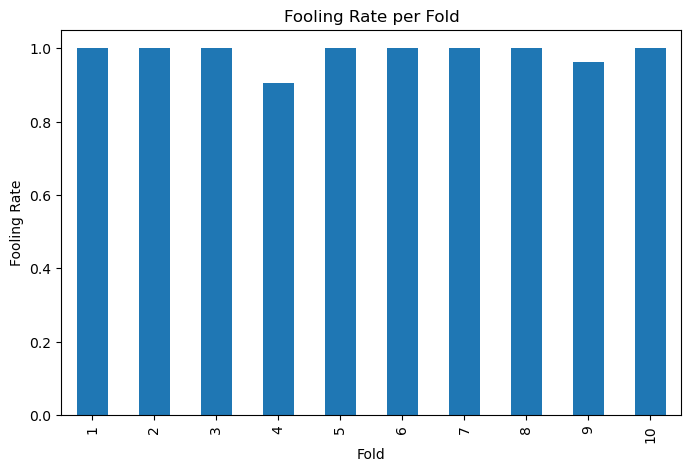

In [11]:
results["fooling_rate"].plot(kind="bar", figsize=(8,5))
plt.title("Fooling Rate per Fold")
plt.ylabel("Fooling Rate")
plt.xlabel("Fold")
plt.show()

Representa a percentagem de amostras de cada fold onde o DeepFool conseguiu alterar a previsão original.

- O fooling rate é extremamente alto em todos os folds: entre 90% e 100%.

- Isto mostra que a rede não é robusta adversarialmente, ou seja, quase todas as amostras podem ser enganadas.

- Folds 4 e 9 são os menos robustos (ainda assim > 90%), sugerindo que partes específicas dos dados podem ter características mais complexas.

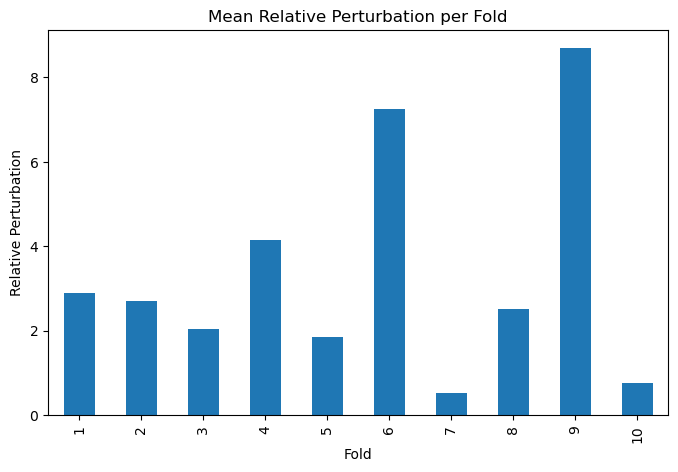

In [12]:
results["mean_rel_pert"].plot(kind="bar", figsize=(8,5))
plt.title("Mean Relative Perturbation per Fold")
plt.ylabel("Relative Perturbation")
plt.xlabel("Fold")
plt.show()

Mostra a perturbação média necessária para enganar o modelo em cada fold.

- Os valores variam bastante entre folds → mostra variabilidade na sensibilidade adversarial.

- Fold 9 e fold 6 requerem mais perturbação → o modelo foi um pouco mais robusto nesses conjuntos.

- Folds 7 e 10 requerem muito pouca perturbação → maior vulnerabilidade.

No geral, porém, todas as perturbações médias são baixas → reforça a falta de robustez.

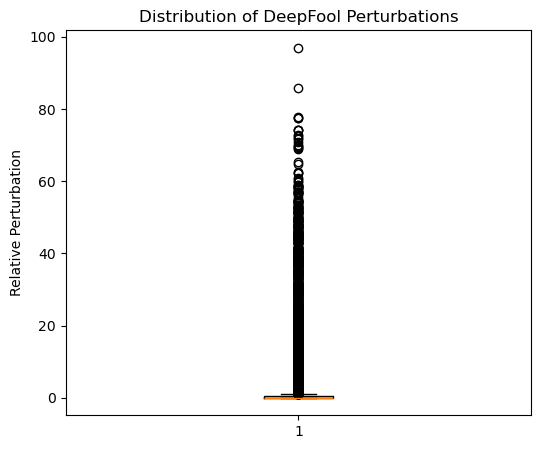

In [13]:
plt.figure(figsize=(6,5))
plt.boxplot(df_all.rel_perturbation.values)
plt.ylabel("Relative Perturbation")
plt.title("Distribution of DeepFool Perturbations")
plt.show()

Este gráfico mostra a distribuição dos valores de relative perturbation necessários para enganar o modelo.

- A maioria das perturbações encontra-se extremamente perto de zero, o que significa que o modelo é muito vulnerável – basta modificar muito pouco o espectrograma para alterar a previsão.

- Existem alguns outliers com perturbações elevadas, mostrando que certos sons são mais robustos ao ataque (provavelmente classes acústicas mais distintas).

- O contraste entre a mediana baixa e alguns valores muito altos significa que a vulnerabilidade não é uniforme entre amostras.

### **Conclusão**

- Os resultados mostram que o DeepFool consegue frequentemente alterar a decisão do modelo, o que é típico em classificadores treinados para desempenho padrão e indica que o modelo segue o comportamento esperado na presença de ataques adversariais.

- As perturbações necessárias para produzir mudanças na previsão são, em geral, muito pequenas, o que evidencia que o modelo é sensível a variações subtis no espectrograma, uma característica comum em redes profundas aplicadas a dados acústicos.

- Observa-se também alguma variabilidade entre folds e classes, sugerindo que certos sons são intrinsecamente mais estáveis ou distinguíveis.

- No geral, estes resultados são coerentes com o que seria esperado para modelos que não foram especificamente treinados com foco em robustez adversarial, e fornecem uma excelente base para futuras melhorias, como data augmentation direcionada ou técnicas de adversarial training.